In [ ]:
from functools import partial
import math

import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import matplotlib.pyplot as plt
import seaborn as sns
import cirpy
import CGRtools
from CGRtools.containers import *
from CGRtools.files import *
import io

# Туториал по работе с химическими данными для задач машинного обучения

## Содержание
1. [Описание данных и инструментов по работе с ними](#описание-данных-и-инструментов-по-работе-с-ними)
    - [Источники данных](#источники-данных)
    - [Качество и полнота данных](#качество-и-полнота-данных)
    - [Как увеличить объем и качество данных?](#как-увеличить-объем-и-качество-данных)
    - [Как данные влияют на результат проекта?](#как-данные-влияют-на-результат-проекта)
    - [Какие существуют бенчмарки по работе с данными?](#какие-бенчмарки-по-работе-с-данными)
    - [Какие используются инструменты для хранения и версионирования данных?](#какие-инструменты-для-хранения-и-версионирования-данных)
    - [Как обеспечить воспроизводимость экспериментов?](#как-обеспечить-воспроизводимость-экспериментов)
2. [Анализ и обработка данных](#анализ-и-обработка-данных)
    - [Обработка сырого датасета](#обработка-сырого-датасета)
    - [Анализ предобработанных данных](#анализ-предобработанных-данных)
    - [Перевод из CAS в SMILES](#перевод-из-cas-в-smiles)
    - [Получение fingerprints из SMILES](#получение-fingerprints-из-smiles)
    - [Обработка растворителей и катализаторов](#обработка-растворителей-и-катализаторов)
3. [Выделение информации из веществ с помощью RDKit](#выделение-информации-из-веществ-с-помощью-rdkit)
4. [Работа с графовым представлением реакций с помощью библиотеки CGRTools](#работа-с-графовым-представлением-реакций-с-помощью-библиотеки-cgrtools)

## Описание данных и инструментов по работе с ними


#### Источники данных

Есть несколько баз данных химических соединений и реакций, которые можно использовать для своих целей. 

**Reaxys**

> *> 105 млн записей соединений с > 500 млн извлеченных фактов об их свойствах: физические, химические, спектральные, экологические, биоактивность* 

> *>41 млн записей реакций включают данные об условиях проведения реакций, растворителях, катализаторах, выходе*

>*16.000 источников (journals, books and patents)*

*Доступ к российским университетам закрыт

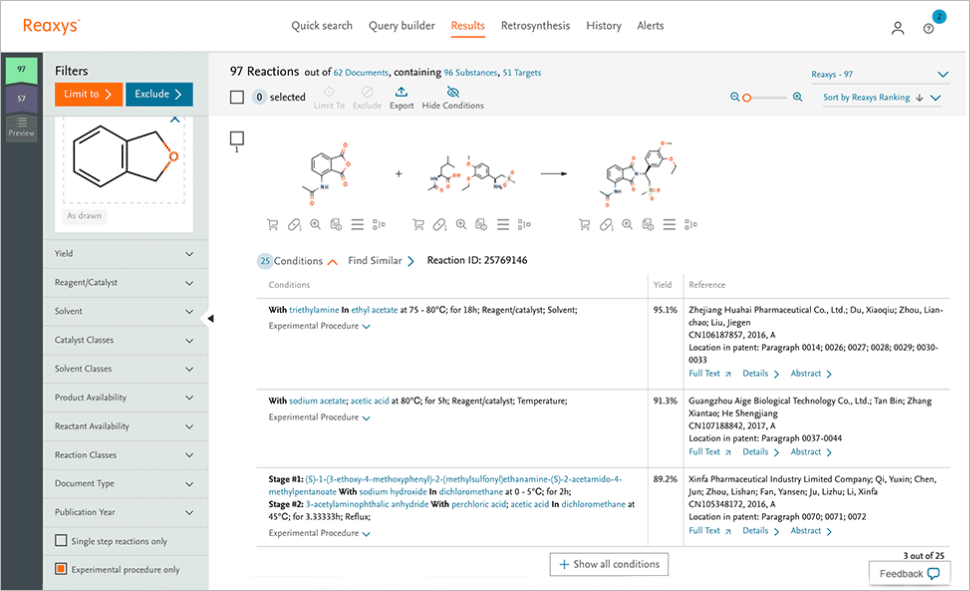


**SciFinder**
> *База данных индексирует статьи из более чем 50 000 научных журналов, начиная с 1907 года, а также патенты из 63 патентных ведомств, в том числе из РФ, Китая, Кореи, Индии.*

> *дополняет Reaxys*

> *больше данных для анализа (NMR, MS)*

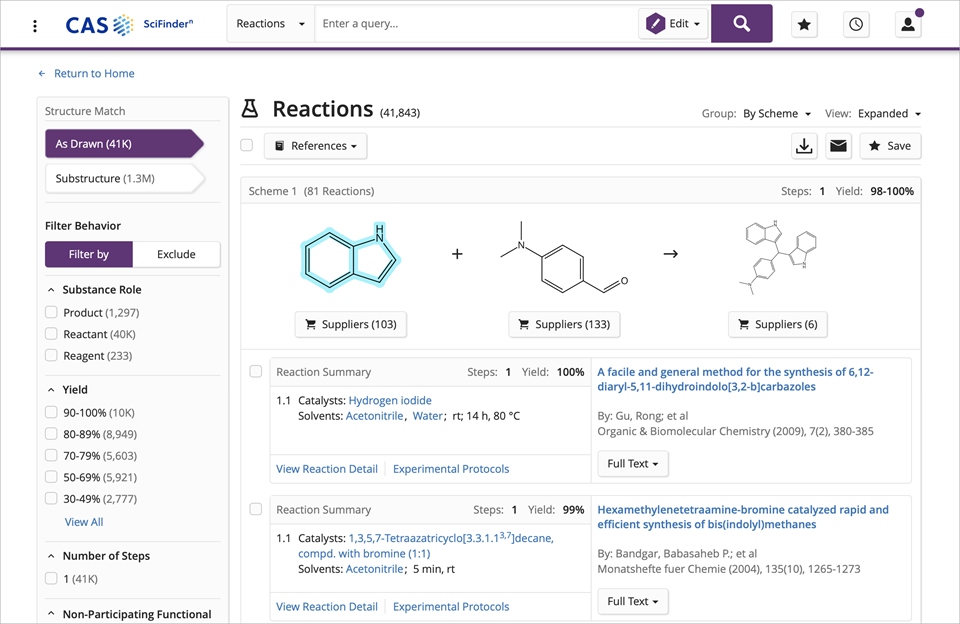

Так же есть база данных химических соединений **PubChem** и патентная база данных **USPTO** с информацией по химическим соединеним и реакциям, но без условий протекания реакций и др.

#### Качество и полнота данных

Важно помнить, что  качество химических данных - довольно сложный аспект. Любые базы данных, содержащие химические соединения, содержат ошибки. Эти ошибки могут возникать по ряду причин, включая ошибки в транскрипции, исторические ошибки (соединение было «правильным» при вводе, но позже было переохарактеризовано), проблемы с графическим представлением и многое другое. Качество химической информации в открытом доступе, как правило, довольно низкое. Это не означает, что данные не представляют ценности, просто необходимо соблюдать осторожность и внимательность при работе с ними. К сожалению, нет центрального органа, ответственного за качество химических данных в открытом доступе. Базы данных химических соединений, такие как PubChem, ChemIDPLus и ChemFinder и т. д., обычно считаются авторитетными с точки зрения достоверности информации. Однако эти источники являются агрегаторами информации, что делает их подверженными риску возникновения разного рода ошибок. Наиболее распространенными являются ошибки в написании идентификаторов структур, а также неточности представления структур в отношении стереохимии. [1]

1. A.J. Williams
Public chemical compound databases
Curr. Opin Drug Discov. Dev., 11 (2008), pp. 393-404

Полнота данных зачастую определяется возможностью решить задачу с помощью этих данных. Что касается нашего проекта, данных довольно много, гораздо больше, чем необходимо. Получить широкую выборку в целом возможно, но сложно оценить действительно ли эта выборка репрезентативна. 

Помимо этого, в самих базах химических данных не учитываются негативные случаи, когда реакция была опробована или расчитана, но не имела никакого экспериментального подтверждения. Поэтому слудет учитывать, что имеется информация только об удачных случаях синтеза.

#### Как увеличить объем и качество данных? 

Для увеличения количества данных необходимо в идеале найти ресурс, который так же обладает максмальной информацией по химическим реакциям, но предоставляет доступ к своему API российским университетам. Иначе же продолжать набирать информацию самостоятельно.

Улучшить качество данных можно будет несколькими способами:

    - проверять вручную
    - использовать библиотеки
    - находить онлайн сервисы проверки
    

#### Как данные влияют на результат проекта?

Коротко говоря, неопределенно. Нет четких правил записи реакций, поэтому выполнение и запись зависит от того, кто публикует информацию. Так же значительно влияет обработка данных: какие дескрипторы были выбраны, как были классифицированы реакции и др. Система настолько многокомпотнетная, что любое изменение может отразится неоожиданным образом. 

#### Какие существуют бенчмарки по работе с данными?

Если вы собираетесь создавать модель, то важно ее оценивать на общепринятых датасетах.
Для ряда задач существуют два бенчмарка:
- Buchwald-Hartwig 
- Suzuki–Miyaura

#### Какие используются инструменты для хранения и версионирования данных?

Помните о бэкапах!
Храните данные распределенно, либо в облаке, либо несколько копий на разных серверах. Создавайте копии промежуточных данных, если их расчет занимает существенное время.

Для версионирования данных можно использовать [DVC](https://dvc.org/). Либо использовать свою систему ведения экспериментов.

#### Как обеспечить воспроизводимость экспериментов?

Минимальным требованием повторения эксперимента является jupyter notebook. Однако он не учитывает версию языка программирования, версии используемых библиотек и использует много повторов кода для разных веток экспериментов. Поэтому для воспроизводимости не только в вашей среде используется poetry или другой менеджер пакетов для контроля версии пакетов и версии python, а так же mlflow или clearml для версионирования экспериментов с разными моделями и параметрами.

## Анализ и обработка данных

Перед тем как использовать данные для моделирования их необходимо очистить. Несмотря на то, что большая часть очистки автоматизирована, оценка качества данных "глазами" все равно должна присуствовать. Химическое понимание данных все еще остается у человека, нельзя им пренебрегать.

#### Обработка сырого датасета 

В этом примере используется датасет из SciFinder, оттуда выгружалась реакция и записывалась в таблицу. Соответвенно в датасет попали всякие разные реакции с различными условиями. Поэтапно стандартизируем датасет.

In [99]:
df = pd.read_csv('../data/interim/dataset_15k_pages_1_stage.csv')

In [100]:
df.head()

,reaction_id,reactants,products,stages_number,yield_value,reference_title,authors,bibliography,reagents_1,catalysts_1,solvents_1,other_conditions_1,folder,file
0,31-480-CAS-42225,['119-53-9'],['134-81-6'],4,90%,Heterogeneous Swern Oxidation. Selective Oxida...,"Firouzabadi, H.","Phosphorus, Sulfur and Silicon and the Related...","['Dimethyl sulfoxide', 'Silica (chlorinated)',...",[],['Dichloromethane'],"5 min, -60 °C",NaN,NaN
1,31-480-CAS-32658,['119-53-9'],['134-81-6'],4,99%,Development of Odorless Thiols and Sulfides an...,"Nishide, Kiyoharu","Monatshefte fuer Chemie (2004), 135(2), 189-200","['Chlorosuccinimide', '1-(Methylthio)dodecane']",[],['Dichloromethane'],-40 °C,NaN,NaN
2,31-480-CAS-21387,['119-53-9'],['134-81-6'],4,91%,Development of Odorless Thiols and Sulfides an...,"Nishide, Kiyoharu","Monatshefte fuer Chemie (2004), 135(2), 189-200","['Oxalyl chloride', 'Dodecyl methyl sulfoxide']",[],['Dichloromethane'],-60 °C,NaN,NaN
3,31-480-CAS-36295,['119-53-9'],['134-81-6'],4,65%,Polymer-supported thioanisole: a versatile pla...,"Choi, Matthew Kwok Wai","Tetrahedron (2004), 60(12), 2875-2879","['tert-Butyl hydroperoxide', 'p-Toluenesulfoni...",['694440-72-7'],"['Dichloromethane', 'Water']",rt,NaN,NaN
4,31-480-CAS-22570757,['119-53-9'],['134-81-6'],4,96%,Alcohol Oxidation in the Presence of Methyl Ch...,"Davidovich, Yuriy A.","ChemistrySelect (2020), 5(23), 7013-7015","['Dimethyl sulfoxide', 'Chlorosulfuric acid, m...",[],['Dichloromethane'],25 °C → -78 °C,NaN,NaN


In [101]:
# Фильтрация по реакциям с одной стадией
df = df[df['stages_number'] == 1].reset_index()
df.head()

,index,reaction_id,reactants,products,stages_number,yield_value,reference_title,authors,bibliography,reagents_1,catalysts_1,solvents_1,other_conditions_1,folder,file
0,38,31-480-CAS-24139,['119-53-9'],['134-81-6'],1,90%,Decomposition products of benzaldehyde,"Zinin, N.","Justus Liebigs Annalen der Chemie (1840), 186-192",['Nitric acid'],[],[],NaN,NaN,NaN
1,39,31-480-CAS-18071,['119-53-9'],['134-81-6'],1,86%,Benzil,"Clarke, H. T.","Organic Syntheses (1926), VI, 6-7","['Pyridine', 'Copper sulfate pentahydrate']",[],['Water'],NaN,NaN,NaN
2,40,31-480-CAS-27637,['119-53-9'],['134-81-6'],1,95%,New reagent for the oxidation of acyloins to d...,"Rigby, W.","Journal of the Chemical Society (1951), 793-5",['Bismuth oxide (Bi2O3)'],[],"['Acetic acid', 'Glycol monoethyl ether']",NaN,NaN,NaN
3,41,31-480-CAS-25495,['119-53-9'],['134-81-6'],1,90%,Reactions of thallium. II. Thallous ethoxide a...,"McHatton, L. P.","Journal of the Chemical Society (1953), 4095-7","['Ethanol, thallium salt']",[],['Ethanol'],NaN,NaN,NaN
4,42,31-480-CAS-37840,['119-53-9'],['134-81-6'],1,32%,New reactions in organoselenium chemistry,"Brewster, Andrew George","1977, (20121004), No pp.",['Phenylseleninyl benzeneseleninate'],[],['Tetrahydrofuran'],NaN,NaN,NaN


In [102]:
# Разделение other_condition на температуру, давление, время и pH
def split_conditions(conditions):
    if conditions is np.nan:
        return []
    conditions = conditions.replace(';', ',')
    return [
        condition.strip() for condition in conditions.split(',')
    ]
print("Before:\n\n", df[df['other_conditions_1'].notnull()]['other_conditions_1'])
df['other_conditions_1'] = df['other_conditions_1'].apply(split_conditions)
print("\n\nAfter:\n\n", df[df['other_conditions_1'].str.len() != 0]['other_conditions_1'])

Before:

 127              reflux
128         2 h, 100 °C
145       2.5 h, reflux
147           2 min, rt
149          6 h, 25 °C
              ...      
279756       3 h, 10 °C
279757     24 h, 100 °C
279758       2 h, 70 °C
279759     20 h, -40 °C
279760               rt
Name: other_conditions_1, Length: 233746, dtype: object


After:

 127              [reflux]
128         [2 h, 100 °C]
145       [2.5 h, reflux]
147           [2 min, rt]
149          [6 h, 25 °C]
               ...       
279756       [3 h, 10 °C]
279757     [24 h, 100 °C]
279758       [2 h, 70 °C]
279759     [20 h, -40 °C]
279760               [rt]
Name: other_conditions_1, Length: 233746, dtype: object


In [103]:
def parse_conditions(conditions, keywords):
    conditions_dict = {
        condition_type: [] for condition_type in keywords.keys()
    }
    for condition in conditions:
        is_match_found = False
        for condition_type, type_keywords in keywords.items():
            for keyword in type_keywords:
                if keyword in condition:
                    conditions_dict[condition_type].append(condition)
                    is_match_found = True
                    break
            if is_match_found:
                break
        if not is_match_found:
            raise ValueError('Unhandled conditions')
    return conditions_dict.values()

keywords = {
    'temperature_1': [' °C', ' K', 'rt', 'heated', 'cooled', 'reflux'],
    'pressure_1': ['Pa', ' atm', ' psi', 'bar', ' torr', ' kg/cm2', 'mm'],
    'time_1': [' d', ' h', ' min', ' s', 'overnight', ' ms', ' w', ' mo'],
    'pH_1': ['pH', 'acidified', 'neutralized', 'basified'],
}
parse_conditions = partial(parse_conditions, keywords=keywords)
conditions = df['other_conditions_1'].apply(parse_conditions)
for column_name, column in zip(keywords.keys(), zip(*conditions)):
    df[column_name] = column

df[keywords.keys()].iloc[2000:2010]

,temperature_1,pressure_1,time_1,pH_1
2000,[rt],[],[],[]
2001,[50 °C],[],[5 h],[]
2002,[reflux],[],[13 h],[]
2003,[80 °C],[],[4 h],[]
2004,[rt → 130 °C],[],[20 h],[]
2005,[140 °C],[],[18 h],[]
2006,[130 °C],[],[6 h],[]
2007,[rt],[],[],[]
2008,[30 °C],[],[24 h],[]
2009,[75 °C],[],[9 h],[]


In [104]:
# Стандартизация времени, температуры, давления и pH
def convert_value(value_string, conversion_mapping):
    for measure, conversion in conversion_mapping.items():
        if measure in value_string:
            value_string = value_string.replace(measure, '')
            return conversion(value_string)
    return value_string


def parse_time(time_list, conversion_mapping):
    converted_time_list = []
    for time_string in time_list:
        symbols_to_remove = ['< ', '> ']
        for symbol in symbols_to_remove:
            time_string = time_string.replace(symbol, '')
        delimiters = [' - ']
        for delimiter in delimiters:
            if delimiter in time_string:
                time_range = time_string.split()
                time_string = parse_range(time_range)
        converted_time_list.append(
            convert_value(time_string, conversion_mapping),
        )
    return converted_time_list


def parse_temperature(temperature_list, conversion_mapping):
    converted_temperature_list = []
    for temperature_string in temperature_list:
        symbols_to_remove = ['< ', '> ']
        for symbol in symbols_to_remove:
            temperature_string = temperature_string.replace(symbol, '')
        if 'reflux' in temperature_string:
            converted_temperature_list.append('reflux')
        elif 'rt' in temperature_string:
            temperature_string = temperature_string.replace('rt', '')
            symbols_to_remove = [' - ', ' → ']
            for symbol in symbols_to_remove:
                if symbol in temperature_string:
                    temperature_string = temperature_string.replace(symbol, '')
                    break
            else:
                converted_temperature_list.append(25.0)
            converted_temperature_list.append(
                convert_value(temperature_string, conversion_mapping),
            )
        elif ' - ' in temperature_string:
            temperature_range = temperature_string.split()
            temperature_string = parse_range(temperature_range)
            converted_temperature_list.append(
                convert_value(temperature_string, conversion_mapping),
            )
        elif ' → ' in temperature_string:
            temperature_range = temperature_string.split()
            temperature_string = parse_range(temperature_range)
            converted_temperature_list.append(
                convert_value(temperature_string, conversion_mapping),
            )
        elif ' ± ' in temperature_string:
            temperature_range = temperature_string.split()
            converted_temperature_list.append(
                convert_value(
                    '{0} {1}'.format(temperature_range[0], temperature_range[-1]),
                    conversion_mapping,
                 ),
            )
        else:
            converted_temperature_list.append(
                convert_value(temperature_string, conversion_mapping),
            )
    return converted_temperature_list


def parse_pressure(pressure_list, conversion_mapping):
    converted_pressure_list = []
    for pressure_string in pressure_list:
        symbols_to_remove = ['< ', '> ']
        for symbol in symbols_to_remove:
            pressure_string = pressure_string.replace(symbol, '')
        delimiters = [' - ', ' → ']
        for delimiter in delimiters:
            if delimiter in pressure_string:
                pressure_range = pressure_string.split()
                pressure_string = parse_range(pressure_range)
        converted_pressure_list.append(
            convert_value(pressure_string, conversion_mapping),
        )
    return converted_pressure_list


def parse_ph(ph_list, conversion_mapping):
    converted_ph_list = []
    for ph_string in ph_list:
        symbols_to_remove = ['< ', '> ']
        for symbol in symbols_to_remove:
            ph_string = ph_string.replace(symbol, '')
        delimiters = [' - ', ' → ']
        for delimiter in delimiters:
            if delimiter in ph_string:
                ph_range = ph_string.split()
                ph_string = parse_range(ph_range, inverted=True)
        converted_ph_list.append(
            convert_value(ph_string, conversion_mapping),
        )
    return converted_ph_list


def parse_range(value_range, inverted=False):
    if len(value_range) == 4:
        left, right, measure = 0, 2, 3
        if inverted:
            left, right, measure = 1, 3, 0
        avg_value = (float(value_range[left]) + float(value_range[right])) / 2
        return '{0} {1}'.format(
            avg_value, value_range[measure],
        )
    elif len(value_range) == 5:
        left, right, measure_left, measure_right = 0, 3, 1, 4
        if inverted:
            left, measure_left = measure_left, left
            right, measure_right = measure_right, right
        if value_range[measure_left] == value_range[measure_right]:
            avg_value = (float(value_range[left]) + float(value_range[right])) / 2
            return '{0} {1}'.format(
                avg_value, value_range[measure_left],
            )
        left, measure = 0, 1
        if inverted:
            left, measure = measure, left
        return '{0} {1}'.format(
            value_range[left], value_range[measure],
        ) 
    else:
        raise ValueError('Wrong range format')

            
time_conversion_mapping = {
    ' d': lambda x: float(x) * 24,
    ' h': lambda x: float(x),
    ' min': lambda x: float(x) / 60,
    ' s': lambda x: float(x) / 60 / 60,
    ' ms': lambda x: float(x) / 60 / 60 / 1000,
    'overnight': lambda _: 12.0,
    ' mo': lambda _: [0],
    ' week': lambda _: [0],
}

temperature_conversion_mapping = {
    ' °C': lambda x: float(x),
    ' K': lambda x: float(x) - 273,
}

pressure_conversion_mapping = {
    ' atm': lambda x: float(x) * 0.10133,
    ' psig': lambda x: float(x) * 0.00689,
    ' psi': lambda x: float(x) * 0.00689,
    ' bar': lambda x: float(x) * 0.1,
    ' kbar': lambda x: float(x) * 100,
    ' kPa': lambda x: float(x) * 0.001,
    ' Pa': lambda x: float(x) * 0.000001,
    ' MPa': lambda x: float(x),
    ' GPa': lambda x: float(x) * 1000,
    ' mbar': lambda x: float(x) * 0.0001,
    ' torr': lambda x: float(x) * 0.000133,
    ' hPa': lambda x: float(x) * 0.0001,
    ' kg/cm2': lambda x: float(x) * 0.0981,
    ' mm Hg': lambda x: float(x) * 0.000133,
    ' mm': lambda x: float(x) * 0.000133,   
}

ph_conversion_mapping = {
    ' pH': lambda x: float(x),
}

In [105]:
parse_time = partial(
    parse_time, conversion_mapping=time_conversion_mapping,
)
parse_temperature = partial(
    parse_temperature, conversion_mapping=temperature_conversion_mapping,
)
parse_pressure = partial(
    parse_pressure, conversion_mapping=pressure_conversion_mapping,
)
parse_ph = partial(
    parse_ph, conversion_mapping=ph_conversion_mapping,
)

In [106]:
df['time_1'] = df['time_1'].apply(parse_time)
df['temperature_1'] = df['temperature_1'].apply(parse_temperature)
df['pressure_1'] = df['pressure_1'].apply(parse_pressure)
df['pH_1'] = df['pH_1'].apply(parse_ph)

mask = df['time_1'].apply(lambda x: [0] not in x)
df = df[mask]

df[keywords.keys()].iloc[2000:2010]

,temperature_1,pressure_1,time_1,pH_1
2001,[50.0],[],[5.0],[]
2002,[reflux],[],[13.0],[]
2003,[80.0],[],[4.0],[]
2004,[130.0],[],[20.0],[]
2005,[140.0],[],[18.0],[]
2006,[130.0],[],[6.0],[]
2007,"[25.0, ]",[],[],[]
2008,[30.0],[],[24.0],[]
2009,[75.0],[],[9.0],[]
2010,[60.0],[],[7.0],[]


In [107]:
# Удаление % из столбца с выходом
def parse_yield(yield_string):
    yield_string = yield_string.replace('%', '')
    return int(yield_string)

print("Before:\n\n", df['yield_value'])
df['yield_value'] = df['yield_value'].apply(parse_yield)
print("\n\nAfter:\n\n", df['yield_value'])

Before:

 0          90%
1          86%
2          95%
3          90%
4          32%
          ... 
279756    100%
279757     85%
279758     85%
279759    100%
279760     45%
Name: yield_value, Length: 279756, dtype: object


After:

 0          90
1          86
2          95
3          90
4          32
         ... 
279756    100
279757     85
279758     85
279759    100
279760     45
Name: yield_value, Length: 279756, dtype: int64


In [108]:
# Разделение ячейки со списком веществ на разные столбцы
# Удаление лишних символов из колонок с названиями веществ
def split_substances(substance):
    if substance is np.nan:
        return [np.nan, np.nan]
    else:
        try:
            substance = eval(substance)
        except SyntaxError:
            return [np.nan, np.nan]
        if not substance:
            return [np.nan, np.nan]
        elif len(substance) == 1:
            return substance + [np.nan]
        return substance[:2]
    
columns_to_split = [
    'reagents_1',
    'solvents_1',
    'catalysts_1',
    'reactants',
    'products',
]

for column_name in columns_to_split:
    second_column_name = '{0}_II'.format(column_name)
    df[column_name], df[second_column_name] = zip(
        *df[column_name].apply(split_substances),
    )
    
df[columns_to_split + [i+'_II' for i in columns_to_split]]

,reagents_1,solvents_1,catalysts_1,reactants,products,reagents_1_II,solvents_1_II,catalysts_1_II,reactants_II,products_II
0,Nitric acid,NaN,NaN,119-53-9,134-81-6,NaN,NaN,NaN,NaN,NaN
1,Pyridine,Water,NaN,119-53-9,134-81-6,Copper sulfate pentahydrate,NaN,NaN,NaN,NaN
2,Bismuth oxide (Bi2O3),Acetic acid,NaN,119-53-9,134-81-6,NaN,Glycol monoethyl ether,NaN,NaN,NaN
3,"Ethanol, thallium salt",Ethanol,NaN,119-53-9,134-81-6,NaN,NaN,NaN,NaN,NaN
4,Phenylseleninyl benzeneseleninate,Tetrahydrofuran,NaN,119-53-9,134-81-6,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
279756,NaN,Toluene,sec-Butyllithium,9011-14-7,106911-77-7,NaN,Cyclohexane,NaN,100-42-5,NaN
279757,NaN,Chloroform,NaN,9011-14-7,696598-57-9,NaN,NaN,NaN,100-42-5,NaN
279758,NaN,Toluene,Azobisisobutyronitrile,9011-14-7,696598-57-9,NaN,NaN,NaN,100-42-5,NaN
279759,NaN,NaN,NaN,9011-14-7,821787-83-1,NaN,NaN,NaN,100-42-5,NaN


In [113]:
# Получение списка растворителей, для которых надо знать reflux, замена reflux на температуры кипения
def replace_reflux(reaction, mapping):
    if reaction['temperature_1'] is np.nan:
        return reaction
    if 'reflux' not in reaction['temperature_1']:
        return reaction
    
    solvent_1 = reaction['solvents_1']
    solvent_2 = reaction['solvents_1_II']
    
    if solvent_1 is not np.nan:
        solvent_1 = solvent_1.lower()
        if solvent_1 in mapping:
            reaction['temperature_1'][0] = mapping[solvent_1]
    if solvent_2 is not np.nan:
        solvent_2 = solvent_2.lower()
        if solvent_2 in mapping:
            reaction['temperature_1'].append(mapping[solvent_2])
        
    return reaction

reflux_df = df[df['temperature_1'].apply(lambda x: 'reflux' in x)]
reflux_solvents = set(reflux_df['solvents_1']).union(
    set(reflux_df['solvents_1_II']),
)
reflux_solvents.remove(np.nan)

boiling_points = pd.read_csv('../data/raw/boiling_points.csv', delimiter=';')
boiling_mapping = dict(
    zip(
        boiling_points['Solvent'],
        boiling_points['Boiling Point (Celsius)'],
    ),
)

mask =df.temperature_1.apply(lambda x: 'reflux' in x)
print("Before:\n\n", df[mask]['temperature_1'])
replace_reflux = partial(replace_reflux, mapping=boiling_mapping)

df = df.apply(replace_reflux, axis=1)

print("\n\nAfter:\n\n", df[mask]['temperature_1'])

Before:

 127       [reflux]
145       [reflux]
151       [reflux]
152       [reflux]
153       [reflux]
            ...   
279409    [reflux]
279535    [reflux]
279584    [reflux]
279587    [reflux]
279594    [reflux]
Name: temperature_1, Length: 29227, dtype: object


After:

 127            [68.7]
145            [81.6]
151            [39.8]
152            [83.5]
153           [110.6]
             ...     
279409    [81.6, 100]
279535          [100]
279584        [110.6]
279587         [83.5]
279594         [83.5]
Name: temperature_1, Length: 29227, dtype: object


In [119]:
# Удаление непонятных слов
temperatures_to_remove = ['cooled', 'heated', 'reflux']
phs_to_remove = ['acidified', 'neutralized', 'basified']

mask1 = df.temperature_1.apply(lambda x: 'heated' in x)
mask2 = df.pH_1.apply(lambda x: 'acidified' in x)
print("Before:\n\n", df[mask1 & mask2][['temperature_1', 'pH_1']])

for temperature in temperatures_to_remove:
    mask = df['temperature_1'].apply(lambda x: temperature not in x)
    df = df[mask]
    
for ph in phs_to_remove:
    mask = df['pH_1'].apply(lambda x: ph not in x)
    df = df[mask]

mask1 = df.temperature_1.apply(lambda x: 'heated' in x)
mask2 = df.pH_1.apply(lambda x: 'acidified' in x)
print("\n\nAfter:\n\n", df[mask1 & mask2][['temperature_1', 'pH_1']])

Before:

       temperature_1         pH_1
42874      [heated]  [acidified]
43063      [heated]  [acidified]
43389      [heated]  [acidified]
43390      [heated]  [acidified]
43391      [heated]  [acidified]
43392      [heated]  [acidified]
43393      [heated]  [acidified]
43394      [heated]  [acidified]
43395      [heated]  [acidified]
43396      [heated]  [acidified]
52953      [heated]  [acidified]
52958      [heated]  [acidified]
53281      [heated]  [acidified]
54233      [heated]  [acidified]


After:

 Empty DataFrame
Columns: [temperature_1, pH_1]
Index: []


In [125]:
# Удаление дублирующейся температуры в пределах одной реакции
def drop_temperature_duplicates(temperature_list):
    if len(temperature_list) > 1:
        if temperature_list[0] == temperature_list[1] or temperature_list[1] == '':
            return [temperature_list[0]]
    return temperature_list
mask = df.temperature_1.str.len() > 1
print("Before:\n\n", df['temperature_1'][mask])
df['temperature_1'] = df['temperature_1'].apply(drop_temperature_duplicates)
print("\n\nAfter:\n\n", df['temperature_1'][mask])

Before:

 147          [25.0, ]
154          [25.0, ]
156          [25.0, ]
167          [25.0, ]
168       [81.6, 100]
             ...     
279728       [25.0, ]
279730       [25.0, ]
279739       [25.0, ]
279754       [25.0, ]
279760       [25.0, ]
Name: temperature_1, Length: 73272, dtype: object


After:

 147            [25.0]
154            [25.0]
156            [25.0]
167            [25.0]
168       [81.6, 100]
             ...     
279728         [25.0]
279730         [25.0]
279739         [25.0]
279754         [25.0]
279760         [25.0]
Name: temperature_1, Length: 73272, dtype: object


#### Анализ предобработанных данных

Сейчас получился датасет с cas-номерами вместо химических соединений.

In [126]:
data = pd.read_csv("../data/interim/dataset_processed.csv", delimiter=';')

In [5]:
data.head()

,reaction_id,reactants,reactants_II,products,stages_number,yield_value,reference_title,authors,bibliography,reagents_1,catalysts_1,solvents_1,temperature_1,pressure_1,time_1,folder,file
0,31-480-CAS-24139,119-53-9,NaN,134-81-6,1,90,Decomposition products of benzaldehyde,"Zinin, N.","Justus Liebigs Annalen der Chemie (1840), 186-192",Nitric acid,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31-480-CAS-18071,119-53-9,NaN,134-81-6,1,86,Benzil,"Clarke, H. T.","Organic Syntheses (1926), VI, 6-7",Pyridine,NaN,Water,NaN,NaN,NaN,NaN,NaN
2,31-480-CAS-27637,119-53-9,NaN,134-81-6,1,95,New reagent for the oxidation of acyloins to d...,"Rigby, W.","Journal of the Chemical Society (1951), 793-5",Bismuth oxide (Bi2O3),NaN,Acetic acid,NaN,NaN,NaN,NaN,NaN
3,31-480-CAS-25495,119-53-9,NaN,134-81-6,1,90,Reactions of thallium. II. Thallous ethoxide a...,"McHatton, L. P.","Journal of the Chemical Society (1953), 4095-7","Ethanol, thallium salt",NaN,Ethanol,NaN,NaN,NaN,NaN,NaN
4,31-480-CAS-37840,119-53-9,NaN,134-81-6,1,32,New reactions in organoselenium chemistry,"Brewster, Andrew George","1977, (20121004), No pp.",Phenylseleninyl benzeneseleninate,NaN,Tetrahydrofuran,NaN,NaN,NaN,NaN,NaN


Если посмотреть только на химические соединения, cas-номера имееют следующие колонки

In [18]:
data[["reaction_id","reactants", "reactants_II","products"]][data[["reaction_id","reactants", "reactants_II","products"]].notnull().all(1)].sample(frac=1).head(10)

,reaction_id,reactants,reactants_II,products
212949,31-287-CAS-24323142,536-74-3,100-44-7,108717-96-0
149692,31-614-CAS-24189120,713-52-0,100-39-0,209528-69-8
227770,31-285-CAS-20685553,71087-82-6,2206-26-0,2380073-59-4
59222,31-041-CAS-9952947,1616402-89-1,100-39-0,1616400-98-6
171341,31-176-CAS-2006985,1002975-60-1,544-97-8,1002975-78-1
132518,31-031-CAS-3926131,147081-29-6,100-39-0,716339-52-5
88061,31-097-CAS-4832249,135-19-3,100-10-7,1788945-75-4
212712,31-614-CAS-30867608,31402-78-5,100-44-7,90074-38-7
163993,31-614-CAS-29855995,137628-16-1,100-39-0,202409-82-3
237538,31-287-CAS-14277456,3815-83-6,100-47-0,1043-46-5


Уберем данные, которые для модели нам не нужны, только для истории.

In [7]:
data = data.drop(['reaction_id', 'reference_title', 'authors', 'bibliography', 'folder', 'file'], axis=1)

In [8]:
data.head()

,reactants,reactants_II,products,stages_number,yield_value,reagents_1,catalysts_1,solvents_1,temperature_1,pressure_1,time_1
0,119-53-9,NaN,134-81-6,1,90,Nitric acid,NaN,NaN,NaN,NaN,NaN
1,119-53-9,NaN,134-81-6,1,86,Pyridine,NaN,Water,NaN,NaN,NaN
2,119-53-9,NaN,134-81-6,1,95,Bismuth oxide (Bi2O3),NaN,Acetic acid,NaN,NaN,NaN
3,119-53-9,NaN,134-81-6,1,90,"Ethanol, thallium salt",NaN,Ethanol,NaN,NaN,NaN
4,119-53-9,NaN,134-81-6,1,32,Phenylseleninyl benzeneseleninate,NaN,Tetrahydrofuran,NaN,NaN,NaN


#### Посмотрим пропуски в данных в %

In [12]:
data.isna().sum() / data.shape[0] * 100

reactants         0.000000
reactants_II     23.966524
products          0.000000
stages_number     0.000000
yield_value       0.000000
reagents_1       30.745237
catalysts_1      55.901963
solvents_1       12.992980
temperature_1    17.956883
pressure_1       96.589951
time_1           31.413528
dtype: float64

Пропуски для второго реактанта является нормой, реакции могут протекать с одним веществом или несколькими. 

Реагенты, катализаторы и растворители - необязательные для реакции условия, любые пропуски для них тоже норма. 

Пропуски по температуре обычно обусловлены либо "забывчивостью" автора источника, либо проблемой перевода источника в базу данных, либо тем, что реакции протекают при нормальных условиях, а температура, соответствующая комнатной, просто не указана. 

Пропуски по давлению имеет те же причины, что и пропуски по температуре, с уточнением, что большинство реакций, изученных человеком, проходят при атмосферном давлении.

#### Проверим числовые признаки. Сначала посмотрим на самый важный признак - выход продукта

Сначала можно посмотреть на боксплоты. У них данные поделены на квантили - 0.25, 0.5, 0.75, концы усов — края статистически значимой выборки (без выбросов). Очевидно медиана у нас смещена и основная часть выходов находится в районе 80%.

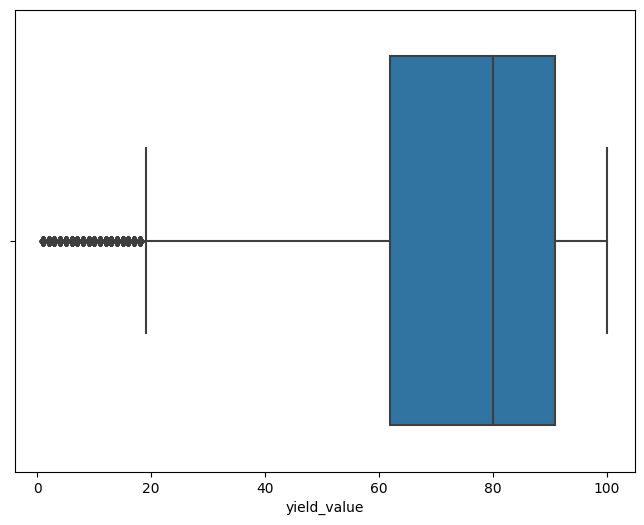

In [127]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(x=data["yield_value"])
plt.show()

На всякий случай посмотрим минмальное, макисмальное и медианное значение. Видно, что ни минимум, ни максимум не выходят за пределы логических значений.

In [45]:
print("Min: ", data["yield_value"].min(), "\nMax: ", data["yield_value"].max(), "\nMedian: ", '{:.2f}'.format(data["yield_value"].mean()))

Min:  1 
Max:  100 
Median:  73.84


И еще можно посмотреть рспределение. Хотелось бы, чтобы оно было практически нормальным. Возможно, по мере заполнения нашего датасета, смещение пика будет не таким сильным.

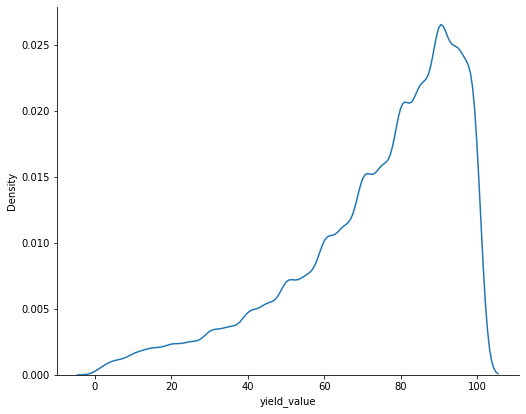

In [29]:
g = sns.displot(x=data["yield_value"], kind="kde")
g.fig.set_size_inches(8,6)

#### Температура, градусы Цельсия

У температуры видно много выбросных значений. 

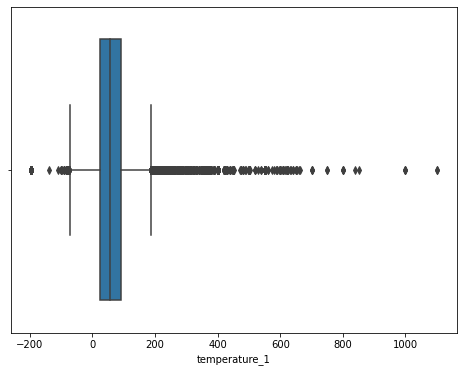

In [47]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(x=data["temperature_1"])
plt.show()

Очевидно, небольшое количество реакций имеет экстремальные значения, лучше проверить насколько они большие и маленькие

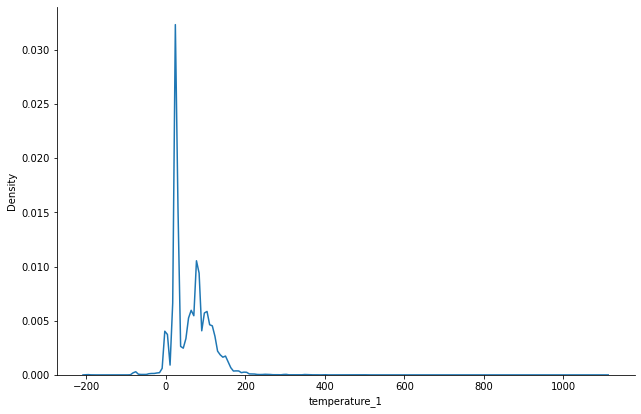

In [54]:
g = sns.displot(x=data["temperature_1"], kind="kde")
g.fig.set_size_inches(10,6)

Краевые значения лучше проверить самостоятельно, чтобы убедиться, что это не выбросы.

In [65]:
print("Min: ", data["temperature_1"].min(), "\nMax: ", data["temperature_1"].max(), "\nMean: ", '{:.2f}'.format(data["temperature_1"].mean()), "\nMedian: ", '{:.2f}'.format(data["temperature_1"].median()))

Min:  -196.0 
Max:  1100.0 
Mean:  61.59 
Median:  56.30


Пока у нас нет точного решения, как выбирать границы температуры, будем решать по ходу формирования итогового датасета.

#### Давление, МПа

С давлением сразу видно, что что-то не то, выкинем самую большую точку:

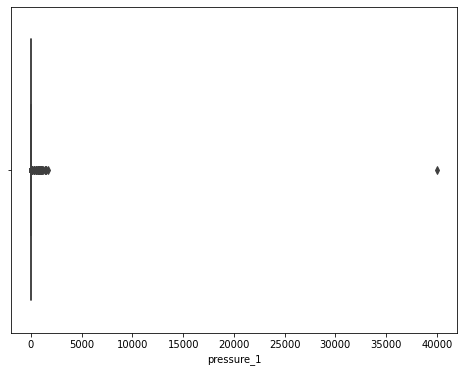

In [55]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(x=data["pressure_1"])
plt.show()

In [60]:
data.query("pressure_1 > 2000")["pressure_1"]

4386    40000.0
Name: pressure_1, dtype: float64

In [61]:
data = data.drop(4386, axis=0)

Видно, что основная масса значений лежит в районе 0, а остальное небольшое количество разнообразных значений выше 0. Что логично, поскольку реакций с большим давлением немного, почти все проходят при атмосферном давлении, примерно равном 0,1 МПа. Это видно и на графиках распределения


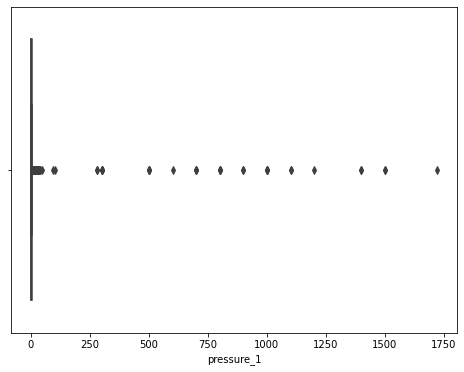

In [62]:
fig = plt.figure(figsize=(8,6))
sns.boxplot(x=data["pressure_1"])
plt.show()

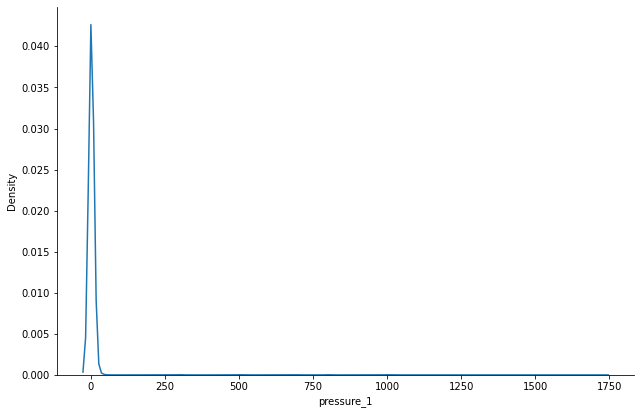

In [63]:
g = sns.displot(x=data["pressure_1"], kind="kde")
g.fig.set_size_inches(10,6)

Минимальное значение однозначно надо перепроверить.

In [66]:
print("Min: ", data["pressure_1"].min(), "\nMax: ", data["pressure_1"].max(), "\nMean: ", '{:.2f}'.format(data["pressure_1"].mean()), "\nMedian: ", '{:.2f}'.format(data["pressure_1"].median()))

Min:  1.33e-10 
Max:  1720.0 
Mean:  4.78 
Median:  0.60


#### Перевод из CAS в SMILES

Универсальным вариантом цифрового представления химических соединений является формат SMILES. Данный формат гибок, поскольку из него возможен перевод во многие другие представления. Есть SMILES канонический и изометрический. Конечно, полностью учесть любой вид изомерии невозможно на данный момент, но частично все же можно.

In [128]:
# Выделяются уникальные значения CAS номеров
cas = pd.unique(data[["reaction_id","reactants", "reactants_II","products"]].values.ravel('K'))
cas

array(['31-480-CAS-24139', '31-480-CAS-18071', '31-480-CAS-27637', ...,
       '1430108-69-2', '290827-82-6', '661451-78-1'], dtype=object)

In [152]:
# Часть нашли с помощью библиотеки
def cas_to_smiles(x):
    smiles = cirpy.resolve(x,'smiles')
    return smiles
smiles = [cas_to_smiles(x) for x in cas[261900:261910]]
smiles

[None,
 'OC1CCCCC1',
 'O=C1CCCCC1',
 'Oc1ccccc1',
 'Sc1ccccc1',
 'Nc1ncccn1',
 None,
 None,
 None,
 None]

In [174]:
# Часть искали в SciFinder
df_cas = pd.read_csv('../data/raw/products_smiles.csv', index_col=None)
df_cas.head()

,query,result,comment
0,132330-98-4,BrC1=NC=CC=C1OCC=2C=CC=CC2,NaN
1,121090-71-9,S1C=2C=CC=CC2SC3=C1C(=CC=C3C(C)C)C(C)C,NaN
2,1071126-38-9,C=1C=CC(=CC1)C2=C(C=3NC=4C=CC=CC4C3CC2)CC,NaN
3,1351653-66-1,O=CN(C)C.O=C([O-])C=1C=CC(=CC1)C2=O[Cd+2]([O-]...,NaN
4,1821197-17-4,[Br-].O=C(NC(CC=1C=CC=CC1)C[P+](C=2C=CC=CC2)(C...,NaN


#### Получение fingerprints из SMILES

Если вы решили работать с fingerprint в качестве дескриптора, то вам нужно выбрать параметр радиуса и nBits. Радиус определеяется размером охватываемых связей, для выбора этого параметра, лучше ознакомится со стуктурой fingerprint. А nBits это размер вектора, который вы хотите получить. Его стоит регулировать относительно размера датасета. 

In [163]:
smiles = df_cas['result'][20:30]
smiles

20    [N-]=[N+]=NC1C(OCC=2C=CC=CC2)C(OCC=3C=CC=CC3)O...
21                            N=1C(=CSC1C=2C=CC=CC2)C=C
22     O=C1OC(OC(=O)C1(CC=2C=CC=CC2)CC=3C=CC=CC3OC)(C)C
23        FC1(F)C(O)C=CC1C(OCC=2C=CC=CC2)COCC=3C=CC=CC3
24                    S=C1NN=C(N1)C=2C=CC(=CC2)C(C)(C)C
25    O=C(OC)N(C(=O)C(C=CC(C(=O)OC)CC=1C=CC=CC1)CC=2...
26    O=C(OC)C1=C(NC(=O)N(CC2=CC=C(F)C=C2)C1CC(=O)NC...
27      O=C(OCC)C1=C(SC2=C(C=NCC=3C=CC=CC3)C(=NN21)C)SC
28    ClC1=NN=C(N=NC(CCC=2C=CC=CC2)C(C=C)C=3C=CC=CC3...
29    N=1C(=NC2=CC=CC(OC3=CC=CC(OC)=C3)=C2C1N)NCC=4C...
Name: result, dtype: object

In [161]:
def get_fingerprint(x, nBits):
    fp_array = np.zeros((0,), dtype=np.int8)
    if x is not None and type(x) != float:
        mol = Chem.MolFromSmiles(x)
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=nBits) 
        ConvertToNumpyArray(fp, fp_array)
        return fp_array
    else:
        return np.zeros((nBits,), dtype=np.int8)

In [164]:
cas = smiles.apply(get_fingerprint, nBits=128).to_frame()
cas

,result
20,"[0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
21,"[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, ..."
22,"[1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
23,"[0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, ..."
24,"[1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, ..."
25,"[1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, ..."
26,"[1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, ..."
27,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, ..."
28,"[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, ..."
29,"[1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, ..."


Создание фингерпринтов помогает отловить ошибки в соедниениях:

In [175]:
smiles = df_cas['result'][0:5]
cas = smiles.apply(get_fingerprint, nBits=128).to_frame()
cas

[19:03:15] Explicit valence for atom # 15 O, 3, is greater than permitted


ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.GetMorganFingerprintAsBitVect(NoneType)
did not match C++ signature:
    GetMorganFingerprintAsBitVect(class RDKit::ROMol mol, unsigned int radius, unsigned int nBits=2048, class boost::python::api::object invariants=[], class boost::python::api::object fromAtoms=[], bool useChirality=False, bool useBondTypes=True, bool useFeatures=False, class boost::python::api::object bitInfo=None, bool includeRedundantEnvironments=False)

Начало ошибки четко сигнализирует в чем проблема: *Explicit valence for atom # 15 O, 3, is greater than permitted*.

#### Обработка растворителей и катализаторов

Основная задача подготовки данных для данного проекта - сделать так, чтобы модель смогла научиться понимать и различать химическую информацию в приближенной к человеку манере. Для этого помимо структуры молекул необходимо сообщить модели информацию о химических свойствах некоторых классов веществ, таких как растворители и катализаторы.
Свойства растворителей в основном определяются так называемыми сольватационными параметрами. [Minnesota Solvent Descriptor Database](https://comp.chem.umn.edu/solvation/mnsddb.pdf) - база данных университета Миннесоты, содержащая в себе информацию о параметрах около 180 растворителей, включая такие физические и химические константы как: показатель преломления оптических частот, параметры Абрахама, поверхностное натяжение, ароматичность, диэлектрическая постоянная и др. Недостатком этой базы данных является неудобный формат pdf, который необходимо перевести в цифровой вид.

Наиболее важным параметром катализатора является его активность, которая может быть определена по энергии поглощения. В базе данных [Catalyst Property Database](https://cpd.chemcatbio.org/) собрана информация об энергиях поглощения поверхностных частиц более чем 1000 катализаторов. База данных постоянно обновляется.

## Выделение информации из веществ с помощью [RDkit](https://rdkit.org/)

Помимо специфических параметров растворителей и катализаторов можно рассчитать более универсальные дескрипторы с помощью библиотеки RDKit.

In [4]:
m = Chem.MolFromSmiles('c1ccccc1C(=O)O')
Descriptors.HeavyAtomCount(m) #количество тяжелых атомов в молекуле, может быть полезно для описания катализаторов, в состав которых входят тяжелые металлы
Descriptors.LabuteASA(m) #площадь поверхности, может быть полезна для описания реакционной способности катализатора.
Descriptors.NumHDonors
Descriptors.NumHAcceptors #количество доноров или акцепторов водородной связи, по которым можно определить силу растворителя

<function rdkit.Chem.Lipinski.<lambda>(x)>

Также RDKit помогает перевести химические соединения в графовый вид. Полный тьюториал по графам можно посмотреть в их документации, а мы покажем только часть.

## Работа с графовым представлением реакций с помощью библиотеки [CGRTools](https://cgrtools.readthedocs.io/)

Библиотека CGRTools позволяет работать с особым видом предстваления реакций - конденсированным графом реакции (Condensed Graph of Recation). Данный формат представляет собой псевдо-молекулу, состоящую из статических (обычных) связей и динамических (образующихся в ходе реакции) связей. CGRTools позволяет преобразовывать различные форматы представления молекул в конденсированные графы происходящих с ними реакций.

In [ ]:
m1 = SMILESRead(io.StringIO('BrC1=CC=C(C=C1)N(=O)=O')).read()
m2 = SMILESRead(io.StringIO('NC1=CC(Br)=CC=C1N(=O)=O')).read()
cgr = m1.compose(m2)
cgr